In [35]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,OneHotEncoder,OrdinalEncoder
from category_encoders import MEstimateEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR

from tensorflow import keras 
import tensorflow as tf

from xgboost import XGBRegressor


In [36]:
train_df = pd.read_csv('train.csv',index_col=0)
test_df = pd.read_csv('test.csv')


X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

X_train.describe()

print(X_train.isnull().sum())

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64


In [37]:
numerical_cols=X_train.select_dtypes(exclude=['object'])
categorical_cols=X_train.select_dtypes(include=['object'])
cols_with_missing_values=[cols for cols in X_train.columns if X_train[cols].isnull().sum().any()]
print(cols_with_missing_values)


['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [38]:
#x train after dropping null columns is x_train_drop
X_train_drop=X_train.copy()
X_train_drop=X_train_drop.dropna(axis=1)

if 'LotFrontage' in X_train.columns:
    print('available')
    # Apply preprocessing steps to 'LotFrontage'
    # ...
else:
    print("Column 'LotFrontage' not found in the DataFrame.")


available


In [39]:
for col in categorical_cols.columns:
    num_unique = categorical_cols[col].nunique()
    print(f"Column {col} has {num_unique} unique values.")
    
#x train after imputing is x_train
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder=  OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('num_imputer', numerical_imputer),
            ('scaler', StandardScaler())  # StandardScaler for numerical features
        ]), numerical_cols.columns),
        ('cat_ordinal', Pipeline(steps=[
            ('cat_ordinal_imputer', categorical_imputer),
            ('cat_ordinal', ordinal_encoder)  # OrdinalEncoder for categorical features with more than 10 unique values
        ]), [col for col in categorical_cols.columns if categorical_cols[col].nunique() >= 10]),
        ('cat_one_hot', Pipeline(steps=[
            ('cat_one_hot_imputer', categorical_imputer),
            ('one_hot', one_hot_encoder)  # OneHotEncoder for categorical features with less than 10 unique values
        ]), [col for col in categorical_cols.columns if categorical_cols[col].nunique() < 10])
    ])


X_train_imputed=preprocessor.fit(X_train)
#X_train_drop=preprocessor.fit(X_train_drop)    

Column MSZoning has 5 unique values.
Column Street has 2 unique values.
Column Alley has 2 unique values.
Column LotShape has 4 unique values.
Column LandContour has 4 unique values.
Column Utilities has 2 unique values.
Column LotConfig has 5 unique values.
Column LandSlope has 3 unique values.
Column Neighborhood has 25 unique values.
Column Condition1 has 9 unique values.
Column Condition2 has 8 unique values.
Column BldgType has 5 unique values.
Column HouseStyle has 8 unique values.
Column RoofStyle has 6 unique values.
Column RoofMatl has 8 unique values.
Column Exterior1st has 15 unique values.
Column Exterior2nd has 16 unique values.
Column MasVnrType has 4 unique values.
Column ExterQual has 4 unique values.
Column ExterCond has 5 unique values.
Column Foundation has 6 unique values.
Column BsmtQual has 4 unique values.
Column BsmtCond has 4 unique values.
Column BsmtExposure has 4 unique values.
Column BsmtFinType1 has 6 unique values.
Column BsmtFinType2 has 6 unique values.

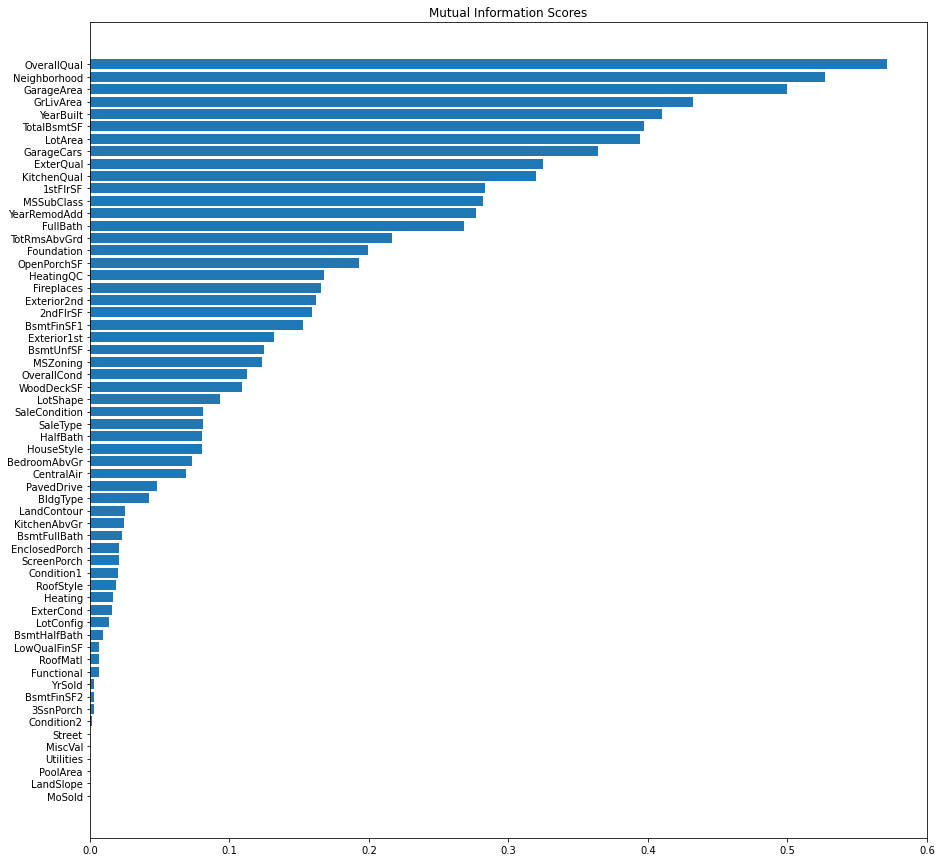

In [40]:

def make_mi_scores(X, y):
    X = X.copy()
    X=X.dropna(axis=1)
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(15,15))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show() 
    
mi_score=make_mi_scores(X_train,y_train)
plot_mi_scores(mi_score)

In [5]:

threshold = 0.1 

selected_features = mi_score[mi_score > threshold].index

X_train_selected_1 = X_train_imputed[selected_features]


NameError: name 'mi_score' is not defined

In [3]:
def rand_forest_mod(X_train,y_train):
    model=RandomForestRegressor(random_state=0)
    param_grid={
        'n_estimator':[i for i in range(50,300,50)],
        'criterion':['gini','entropy'],
        'bootstrap':[True,False],
        'max_features':['auto','log2','sqrt','None']
        
    }
    
    search_cv=GridSearchCV(model,param_grid,cv=5)
    search_cv.fit(X_train,y_train)
    best_params = search_cv.best_params_
    best_model = search_cv.best_estimator_
    best_score=search_cv.best_score_
    
    return best_model,best_params,best_score
    

In [4]:
def xgb_reg(X_train,y_train):
    model=XGBRegressor()
    
    param_grid = {
    'n_estimators': [i for i in range(100,1000,80)],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.05,0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_param=grid_search.best_params_
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    
    return best_estimator,best_param,best_score


In [ ]:
def decision_tree(X_train,y_train):
    model=DecisionTreeRegressor(random_state=0)
    param_grid={
        'criterion':['gini','entropy'],
        'max_features':['auto','log2','sqrt','None']
    }
    grid_search=GridSearchCV(model,param_grid,cv=5)
    best_param=grid_search.best_params_
    best_estimator=grid_search.best_estimator_
    best_score=grid_search.best_score_
    
    return best_param,best_estimator,best_score
    

In [ ]:
def adaboost(X_train,y_train):
    model=AdaBoostRegressor()
    param_grid={
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [ ]:
def linear_reg(X_train,y_train):
    model=LinearRegression()
    param_grid={
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [ ]:
def lasso(X_train,y_train):
    model=Lasso()
    param_grid={
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    

In [ ]:
def svm_svr(X_train,y_train):
    model=SVR()
    param_grid={
        
    }
    
    grid_search=GridSearchCV(model,param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    best_score=grid_search.best_score_
    best_estimator=grid_search.best_estimator_
    best_params=grid_search.best_params_
    
    return best_score,best_estimator,best_params
    